# Delft 3D Verify 

This code will compare experimental data to the simulated data on Delft3D.


This experimental data was collected during a flume test as documented in this citation. THE nondimentaionalized data is loi
>   P. Mycek, B. Gaurier, G. Germain, G. Pinon, and E. Rivoalen, “Experimental study of the turbulence intensity effects on marine current turbines behaviour. Part I: One single turbine,” Renew. Energy, vol. 66, pp. 729–746, 2014, doi: 10.1016/j.renene.2013.12.036.  
```
u*flow rate (ex:0.8 m/s)= raw velocity 
y=0 at center of flume 
Downstream*diameter of turbine(ex:0.7)= meters downstream 
Velocity 15% inlet TI
    u*	y*	Downstream
0.51	0	1.2
0.595	0	2
0.788	0	3
0.862	0	4
0.911	0	5
0.913	0	6
0.927	0	7
0.953	0	8
0.965	0	9
0.954	0	10
```

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
from math import isclose
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4
import math
plt.rcParams.update({'font.size': 15}) # Set fount size of plots title and labels 

## Experimental data

In [2]:
#Experimental data
ucx_experiment= np.array([0.51, 0.595, 0.788, 0.862, 0.911, 0.913, 0.927, 0.953, 0.965, 0.954])*0.8
ucx_experiment

array([0.408 , 0.476 , 0.6304, 0.6896, 0.7288, 0.7304, 0.7416, 0.7624,
       0.772 , 0.7632])

##  Simulated Data

In [3]:
# Downloading Data
datadir = normpath(join(relpath(join('data', 'river', 'd3d'))))
filename= 'Flume_verify_map.nc' 
d3d_data = netCDF4.Dataset(join(datadir,filename)) 

In [4]:
# Getting variable data 
variable= 'ucx' 
var_data_df= d3d.get_all_data_points(d3d_data, variable, time_index=-1)
print(var_data_df)


          x    y         z       ucx   time
0       0.1  1.1  0.202950  0.574381  300.0
1       0.3  1.1  0.199856  0.553903  300.0
2       0.1  1.3  0.202950  0.574381  300.0
3       0.5  1.1  0.199620  0.559200  300.0
4       0.3  1.3  0.199856  0.553903  300.0
...     ...  ...       ...       ...    ...
14995  17.7  4.7  1.800352  0.991075  300.0
14996  17.5  4.9  1.800339  0.974297  300.0
14997  17.9  4.7  1.799982  1.004194  300.0
14998  17.7  4.9  1.800352  0.990769  300.0
14999  17.9  4.9  1.799982  1.003858  300.0

[15000 rows x 5 columns]


### Creating Points to interpolate onto 

In [5]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()
print(np.unique(var_data_df.z))

# Creating one array and 2 points 
turbine_diameter= 0.7 #meters
turbine_x=6
x = np.array([1.2, 2, 3, 4, 5, 6, 7, 8, 9, 10])*turbine_diameter+turbine_x
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

# Creating an array of points  
cline_points = d3d.create_points(x, y, z)
cline_points

[0.19689158 0.19689158 0.19732385 ... 1.80038056 1.80041568 1.80045194]
0


,x,y,z
0,6.84,3.0,0.998672
1,7.40,3.0,0.998672
2,8.10,3.0,0.998672
3,8.80,3.0,0.998672
4,9.50,3.0,0.998672
5,10.20,3.0,0.998672
6,10.90,3.0,0.998672
7,11.60,3.0,0.998672
8,12.30,3.0,0.998672
9,13.00,3.0,0.998672


### Plotting Results

[0.57889599 0.58610082 0.61623683 0.63986001 0.65766252 0.67163934
 0.68321058 0.69297474 0.70143772 0.7088273 ]


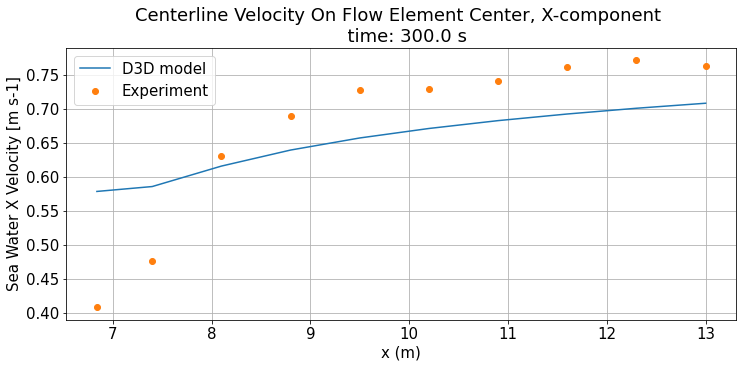

In [6]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']]) 
print(cline_variable)
# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
Model= plt.plot(x, cline_variable, label="D3D model")
Exp=plt.plot(x, ucx_experiment,'o', label="Experiment")
plt.grid()
plt.xlabel('x (m)')

y_name= f'{d3d_data.variables[variable].standard_name}'
y_label=' '.join([x.capitalize() for x in y_name.split('_')])
plt.ylabel(f'{y_label} [{d3d_data.variables[variable].units}]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  time: {var_data_df.time[1]} s')
plt.legend()

### standard devation

In [17]:
 # Square deviations
deviations = (cline_variable - ucx_experiment)**2
# Variance
print (deviations)

sum(deviations)/10

[0.02920544 0.01212219 0.0002006  0.00247407 0.00506054 0.00345282
 0.00340932 0.00481987 0.00497904 0.00295639]


0.006868026422263839

[0, 1, 2]


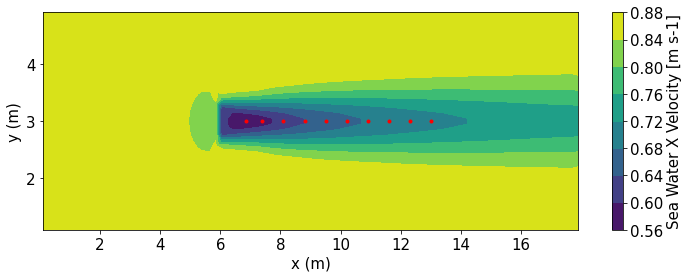

In [7]:
x_contour = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z_contour = np.mean([zmin,zmax])

contour_points = d3d.create_points(x_contour, y_contour, z_contour) 


contour_variable = interp.griddata(var_data_df[['x','y','z']], 
                                                     var_data_df[variable],
                                                     contour_points[['x','y','z']])


# Plotting 
Type= 'Contour'
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_variable)
                               #vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.plot(cline_points['x'], cline_points['y'], '.', color= 'red')

plt.xlabel('x (m)')
plt.ylabel('y (m)')
title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
#plt.title(f'{Type} {title_label} \n  Layer: {layer}')

cbar= plt.colorbar(contour_plot)
cbar_name= f'{d3d_data.variables[variable].standard_name}'
cbar_label=' '.join([x.capitalize() for x in cbar_name.split('_')])
cbar.set_label(f'{cbar_label} [{d3d_data.variables[variable].units}]')